In [29]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#load in cleaned and transformed data file
df = pd.read_csv("Data\\Export\\central_dem_grades_clean.csv")

#convert date of birth column from str to datetime type, extract year, drop date column
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], format = '%Y-%m-%d')
df['Birth_Year'] = df['Date_of_Birth'].dt.year
df = df.drop('Date_of_Birth', axis = 1)

#show first 5 rows
#df.head()
df.shape

(848, 29)

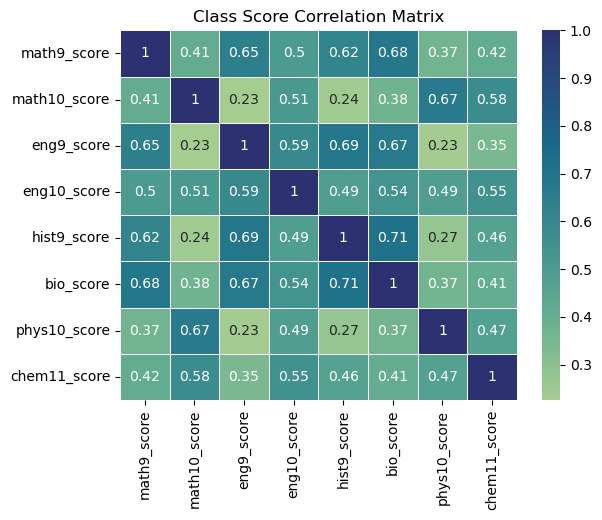

In [30]:
import seaborn as sns
core_courses = ['math9_score', 'math10_score', 'eng9_score', 'eng10_score', 
                'hist9_score', 'bio_score', 'phys10_score', 'chem11_score']

corr_matrix = df[core_courses].corr()
#corr_matrix['chem11_score']

fig, ax = plt.subplots()
sns.heatmap(corr_matrix, annot=True, cmap = "crest", linewidths= 0.5)
ax.set(title= 'Class Score Correlation Matrix')

plt.show()

In [31]:
#asscociation rule mining for categorical data and Chem Grades
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

all_categories = ['ID', 'chem11', 'Gender', 'Counselor', 'ELL_Status', 
                  'Double_Math', 'FRPL_Status', 'Home_Language', 
                  'Race_Ethnicity', 'Special_Education_Status']

#replace coded values with text (must be string for encoder to work) for each column
df_rules = df[all_categories].set_index('ID')
df_rules['chem11'] = df_rules['chem11'].replace({0: 'No Chem', 1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
df_rules['Gender'] = df_rules['Gender'].replace({0: 'Female', 1: "Male"})
df_rules['Counselor'] = df_rules['Counselor'].astype(str)
df_rules['ELL_Status'] = df_rules['ELL_Status'].replace({False: 'NonELL', True: "ELL"})
df_rules['Double_Math'] = df_rules['Double_Math'].replace({0: 'Math1', 1: "Math2"})
df_rules['FRPL_Status'] = df_rules['FRPL_Status'].replace({1: 'Paid Lunch', 2: "Reduced Lunch", 3: "Free Lunch"})
df_rules['Home_Language'] = df_rules['Home_Language'].replace({0: 'English', 1: "Spanish"})
df_rules['Home_Language'] = df_rules['Home_Language'].replace([2, 3, 4, 5, 6], "Other")
df_rules['Race_Ethnicity'] = df_rules['Race_Ethnicity'].replace({5: 'White', 4: "Asian", 3: "Hispanic", 2: "Black", 1: "Multi", 0: "Native"})
df_rules['Special_Education_Status'] = df_rules['Special_Education_Status'].replace({False: 'NoSPED', True: "SPED"})

#convert df to list of lists
list_rules = df_rules.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(list_rules).transform(list_rules)
df_rules2 = pd.DataFrame(te_ary, columns=te.columns_)

#create df of most common occuring demographic info
frequent_itemsets = fpgrowth(df_rules2, min_support=0.05, use_colnames=True)

#create rules based on lift metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
#rules.sort_values(['lift'], ascending = False)

#extract rules for Chem1
rules[rules["consequents"].apply(lambda x: 'Chem 1' in str(x))].sort_values(['lift'], ascending = False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
20872,"(Paid Lunch, NoSPED)","(Hispanic, NonELL, Chem 1)",0.219340,0.112028,0.050708,0.231183,2.063611,0.026135,1.154984,0.660226
20857,"(Paid Lunch, Hispanic, NonELL, NoSPED)",(Chem 1),0.133255,0.188679,0.050708,0.380531,2.016814,0.025565,1.309704,0.581680
20901,"(Paid Lunch, NonELL, NoSPED, Math1)",(Chem 1),0.168632,0.188679,0.062500,0.370629,1.964336,0.030683,1.289099,0.590499
20861,"(Paid Lunch, NonELL, NoSPED)","(Hispanic, Chem 1)",0.192217,0.134434,0.050708,0.263804,1.962329,0.024867,1.175727,0.607096
20911,"(Paid Lunch, Math1, NoSPED)","(NonELL, Chem 1)",0.195755,0.166274,0.062500,0.319277,1.920191,0.029951,1.224766,0.595861


In [32]:
#asscociation rule mining for categorical data and Chem Grades
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

all_categories = ['ID', 'chem11', 'Counselor']

#replace coded values with text (must be string for encoder to work) for each column
df_rules = df[all_categories].set_index('ID')
df_rules['chem11'] = df_rules['chem11'].replace({0: 'No Chem', 1: "Chem 1", 2: "Chem 1 Hon", 5: "Chem 1 Bi"})
df_rules['Counselor'] = df_rules['Counselor'].astype(str)


#convert df to list of lists
list_rules = df_rules.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(list_rules).transform(list_rules)
df_rules2 = pd.DataFrame(te_ary, columns=te.columns_)

#create df of most common occuring demographic info
frequent_itemsets = fpgrowth(df_rules2, min_support=0.05, use_colnames=True)

#create rules based on lift metric
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
rules.sort_values(['lift'], ascending = False)

#extract rules for Chem1
#rules[rules["consequents"].apply(lambda x: 'Chem 1' in str(x))].sort_values(['lift'], ascending = False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(34),(No Chem),0.095519,0.741745,0.081368,0.851852,1.148443,0.010517,1.743219,0.142906
0,(19),(No Chem),0.120283,0.741745,0.100236,0.833333,1.123476,0.011016,1.549528,0.124933
3,(37),(No Chem),0.080189,0.741745,0.063679,0.794118,1.070607,0.004200,1.254380,0.071700
5,(22),(No Chem),0.101415,0.741745,0.077830,0.767442,1.034643,0.002606,1.110495,0.037262
1,(10),(No Chem),0.095519,0.741745,0.073113,0.765432,1.031934,0.002263,1.100981,0.034214
8,(28),(No Chem),0.074292,0.741745,0.055425,0.746032,1.005779,0.000318,1.016878,0.006207
7,(31),(No Chem),0.130896,0.741745,0.091981,0.702703,0.947364,-0.005111,0.868675,-0.060087
4,(25),(No Chem),0.121462,0.741745,0.082547,0.679612,0.916233,-0.007547,0.806068,-0.094256
6,(13),(No Chem),0.095519,0.741745,0.063679,0.666667,0.898781,-0.007171,0.774764,-0.110725
9,(16),(No Chem),0.084906,0.741745,0.051887,0.611111,0.823883,-0.011092,0.664084,-0.189364


In [33]:
#dimensionality reduction for ML 
#Factor analysis of mixed data https://pypi.org/project/prince/0.7.1/
from prince import FAMD

df_ML= df

df_ML['Chem11_grade'] = pd.cut(x=df_ML['chem11_score'], 
                                     bins=[0, 59.5, 69.5, 79.5, 89.5, 100],
                                     labels = ['F', 'D', 'C', 'B', 'A'])

df_ML_train = df_ML[df_ML['chem11']>0]
df_ML_test = df_ML[df_ML['chem11'] == 0]

#reset index to id 
df_ML_train = df_ML_train.set_index(['ID'])
df_ML_test = df_ML_test.set_index(['ID'])

#extract labels and drop nan
df_ML_train = df_ML_train.dropna()
df_ML_labels = df_ML_train[['chem11', 'chem11_score', 'Chem11_grade']]
df_ML_train = df_ML_train.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis = 1)


df_ML_test = df_ML_test.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis = 1)
df_ML_test = df_ML_test.dropna()

[Text(0.5, 1.0, 'Chem scores based on attributes'),
 Text(0.5, 0, 'Factor Analysis Score'),
 Text(0, 0.5, 'Chem11 Score')]

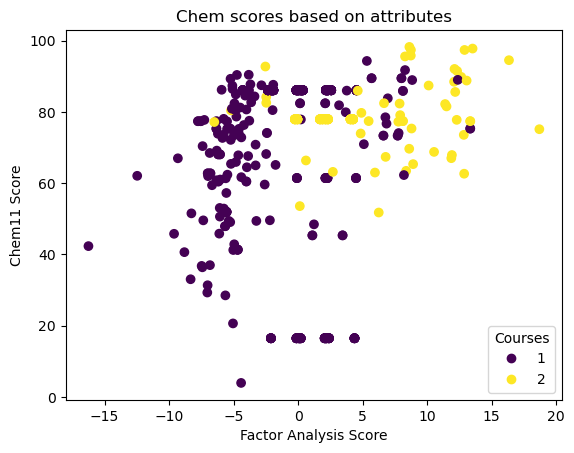

In [34]:
#dimensionality reduction to plot chem scores vs other factors

#set up FAMD method
famd_1D = FAMD(n_components=1,n_iter=3,copy=True,check_input=True,engine='sklearn', random_state=42)

#use function to reduce dimensionality
famd_1D =famd_1D.fit(df_ML_train)
df_ML_train_reduced_1D = famd_1D.row_coordinates(df_ML_train)

#join reduced datafram with labeled data based on ID
df_ML_train_reduced_1D_labels = df_ML_train_reduced_1D.join(df_ML_labels[['chem11', 'chem11_score']]).reset_index()

#create graph of reduced component and chem score with colors for courses
x = df_ML_train_reduced_1D_labels[0]
y = df_ML_train_reduced_1D_labels['chem11_score']
c = df_ML_train_reduced_1D_labels['chem11']

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=c)

#create legend
legend = ax.legend(*scatter.legend_elements(),
                   title = 'Courses', 
                   loc = 'lower right')
ax.set(title= "Chem scores based on attributes", xlabel = 'Factor Analysis Score',
     ylabel = 'Chem11 Score')


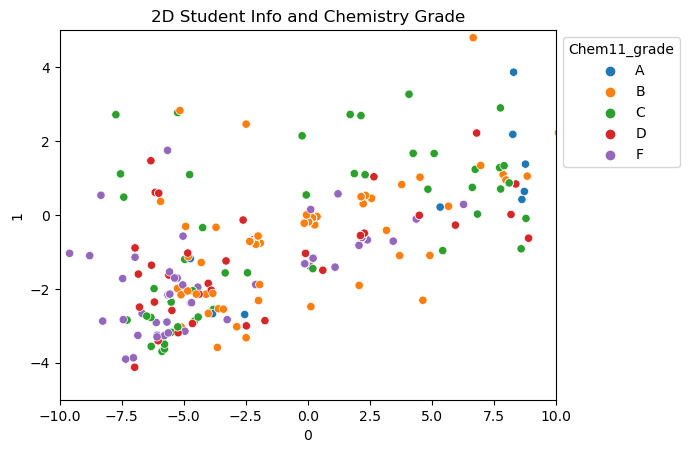

In [35]:
#set up FAMD method
famd_2D = FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)
#famd2_2D = FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)

#reduce dimensions for training set
famd_2D =famd_2D.fit(df_ML_train)
df_ML_train_reduced_2D = famd_2D.row_coordinates(df_ML_train)

#join reduced data with labels
df_ML_train_reduced_2D_labels = df_ML_train_reduced_2D.join(df_ML_labels['Chem11_grade']).reset_index()

#reduce dimensions for testing set
#famd2_2D =famd2_2D.fit(df_ML_test)
#df_ML_test_reduced_2D = famd2_2D.row_coordinates(df_ML_test)
#df_ML_test_reduced_2D = df_ML_test_reduced_2D.reset_index()

#plot 2D data
x = df_ML_train_reduced_2D_labels[0]
y = df_ML_train_reduced_2D_labels[1]
colors = df_ML_train_reduced_2D_labels['Chem11_grade']

fig, ax = plt.subplots()
sns.scatterplot(x = x, y = y, hue=colors, hue_order = ['A', 'B', 'C', 'D', 'F'])
ax.set(xlim = (-10, 10), ylim = (-5, 5), title = "2D Student Info and Chemistry Grade")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


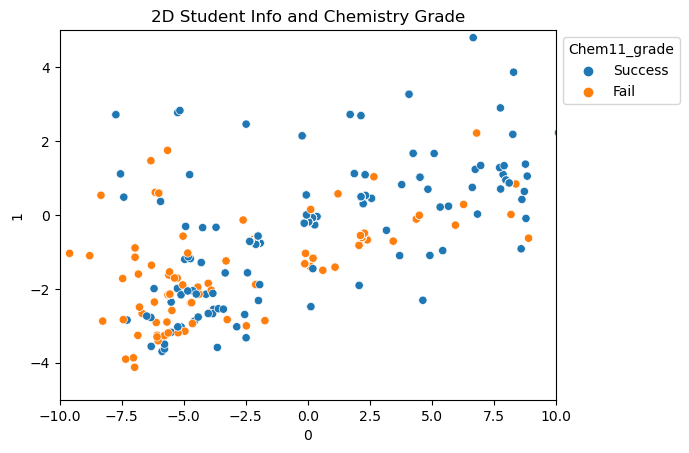

In [36]:
#set up FAMD method
df_ML_PF = df_ML

df_ML_PF['Chem11_grade'] = df_ML_PF['Chem11_grade'].replace(['A', 'B', 'C'], 'Success')
df_ML_PF['Chem11_grade'] = df_ML_PF['Chem11_grade'].replace(['D', 'F'], 'Fail')

df_ML_PF['Chem11_grade'].head()

df_ML_PF = df_ML_PF[df_ML_PF['chem11']>0]

#reset index to id 
df_ML_PF = df_ML_PF.set_index(['ID'])


#extract labels and drop nan
df_ML_PF = df_ML_PF.dropna()
df_ML_PF_labels = df_ML_PF[['chem11', 'chem11_score', 'Chem11_grade']]
df_ML_PF = df_ML_PF.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis = 1)

#set up FAMD method
famd_2D_PF = FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='sklearn',random_state=42)

#reduce dimensions for training set
famd_2D_PF =famd_2D_PF.fit(df_ML_train)
df_ML_PF_reduced_2D = famd_2D_PF.row_coordinates(df_ML_train)

#join reduced data with labels
df_ML_PF_reduced_2D_labels = df_ML_PF_reduced_2D.join(df_ML_PF_labels['Chem11_grade']).reset_index()

#plot 2D data
x = df_ML_PF_reduced_2D_labels[0]
y = df_ML_PF_reduced_2D_labels[1]
colors = df_ML_PF_reduced_2D_labels['Chem11_grade']

fig, ax = plt.subplots()
sns.scatterplot(x = x, y= y, hue=colors, hue_order = ['Success', 'Fail'])
ax.set(xlim = (-10, 10), ylim = (-5, 5), title = "2D Student Info and Chemistry Grade")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [37]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#create list of categorical features
category_features = ['Gender', 'Counselor', 'ELL_Status', 'schoolName']

#use one hot encoder method to create an array of encoded data
ohn_data = pd.DataFrame(ohe.fit_transform(df[category_features]).toarray())

#create a dictionary of the encoded columns with meaningful names
ohn_columns = {0: 'Female', 1: 'Male', 2: 'Counselor10', 3: 'Counselor13', 4: 'Counselor16', 5: 'Counselor16', 6: 'Counselor19',
               7: 'Counselor22', 8: 'Counselor25', 9: 'Counselor28', 10: 'Counselor31', 11: 'Counselor34', 12: 'Counselor37', 
               13: 'Non-ELL', 14: 'ELL'}

#replace the column names with meaningful names
ohn_data = ohn_data.rename(columns=ohn_columns)

#create new df by joining categorical data array with non categorical array 
new_df_full = df.join(ohn_data)

#drop non encoded categorical data
new_df_full = new_df_full.drop(category_features, axis=1)
new_df_full['Transfer_Student'] = new_df_full['Transfer_Student'].astype(int)
new_df_full['Special_Education_Status'] = new_df_full['Transfer_Student'].astype(int)


#drop all missing values 
new_df = new_df_full.dropna()

#create new idexes
new_df = new_df.set_index('ID')

#create a new new df that will store grades as 'success' or 'failure'
new_df_PF = new_df

#replace grades with 'success' or 'failure'
new_df_PF['Chem11_grade'] = new_df_PF['Chem11_grade'].replace(['A', 'B', 'C'], 'Success')
new_df_PF['Chem11_grade'] = new_df_PF['Chem11_grade'].replace(['D', 'F'], 'Fail')


In [38]:
#KNN Supervised ML for predition of which students would have success in Chem
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier


from sklearn.neighbors import KNeighborsClassifier

# Create feature and target arrays
X = new_df_PF.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
X = X.values
y = new_df_PF['Chem11_grade']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)
  
knn = KNeighborsClassifier(n_neighbors=3)
  
knn.fit(X_train, y_train)
  
# Predict on dataset which model has not seen before
predKNN =knn.predict(X_test) 

#print statistics to measure the model's performance 
print("Confusion Matrix: \n", confusion_matrix(y_test, predKNN))
print("Accuracy Score:", accuracy_score(predKNN,y_test))
#print("Precision:", precision_score(pred, y_test))
#print("Recall:", recall_score(pred, y_test))

Confusion Matrix: 
 [[17  5]
 [ 1 20]]
Accuracy Score: 0.8604651162790697


In [39]:
#SVM method to predict student success in Chem
from sklearn import svm
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

# Create feature and target arrays
X = new_df_PF.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
X = X.values
y = new_df_PF['Chem11_grade']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

svm1 = svm.SVC(kernel = 'linear', C = 0.75)
svm1.fit (X_train, y_train)

y_train_predSVM = svm1.predict(X_train)
y_test_predSVM = svm1.predict(X_test)

print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_predSVM))
print("Accuracy Score:", accuracy_score(y_test_predSVM, y_test))

Confusion Matrix: 
 [[17  5]
 [ 3 18]]
Accuracy Score: 0.813953488372093


In [40]:
#decision tree model for success prediction 
from sklearn import tree

# Create feature and target arrays
X = new_df_PF.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
X = X.values
y = new_df_PF['Chem11_grade']
y = y.values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=903)

tree1 = tree.DecisionTreeClassifier(criterion="log_loss", max_depth= 4, random_state= 0)
tree1 = tree1.fit(X_train, y_train)

pred_tree = tree1.predict(X_test)

print("Confusion Matrix: \n", confusion_matrix(y_test, pred_tree))
print("Accuracy Score:", accuracy_score(pred_tree, y_test))

Confusion Matrix: 
 [[19  3]
 [ 3 18]]
Accuracy Score: 0.8604651162790697


In [41]:
#make prediction for students who didn't enroll in chemistry

#create datafram of student info who didn't take chemistry
df_no_chem = new_df_full[new_df_full['chem11']==0]

#drop chem grades (they are nan), they drop all other nan
df_no_chem = df_no_chem.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
df_no_chem = df_no_chem.dropna()
df_no_chem = df_no_chem.set_index('ID')

#create array
no_chem = df_no_chem.values

#use models to make predictions
predKNN_no_chem =knn.predict(no_chem) 
predSVM_no_chem =svm1.predict(no_chem) 
predTREE_no_chem =tree1.predict(no_chem) 

#add predictions to dataframe 
df_no_chem['KNN'] = predKNN_no_chem
df_no_chem['SVM'] = predSVM_no_chem
df_no_chem['Tree'] =predTREE_no_chem

df_no_chem[['KNN', 'SVM', 'Tree']].head()



,KNN,SVM,Tree
ID,,,
2240026,Fail,Fail,Fail
2240026,Fail,Fail,Fail
2240027,Fail,Fail,Fail
2240033,Fail,Fail,Fail
2240033,Fail,Fail,Fail


In [67]:
#Prepare data for clustering (normalize & feature selection)
from sklearn.preprocessing import Normalizer
from factor_analyzer.factor_analyzer import FactorAnalyzer 

#drop missing data
full_no_chem = new_df_full.drop(['chem11', 'chem11_score', 'Chem11_grade'], axis=1)
full_no_chem = full_no_chem.set_index(['ID'])
full_no_chem = full_no_chem.dropna()

scaler = Normalizer()
scaled_data = scaler.fit_transform(full_no_chem)
scaled_full_no_chem = pd.DataFrame(scaled_data, columns = full_no_chem.columns)

scaled_full_no_chem.head()


#analyze features
#fa = FactorAnalyzer(rotation=None, bounds = (0.01, 1))
#fa.fit(all_chem_dropped)
#ev, v = fa.get_eigenvalues
#ev




,math9,math9_score,math10,math10_score,eng9,eng9_score,eng10,eng10_score,hist9,hist9_score,...,Counselor16,Counselor19,Counselor22,Counselor25,Counselor28,Counselor31,Counselor34,Counselor37,Non-ELL,ELL
0,0.002477,0.044594,0.000495,0.040352,0.002477,0.042116,0.000991,0.046818,0.000991,0.044594,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000495,0.000495,0.0,0.000495
1,0.000496,0.040602,0.000496,0.038315,0.000992,0.034408,0.000992,0.042051,0.000992,0.036536,...,0.0,0.0,0.000496,0.0,0.0,0.0,0.000000,0.000496,0.0,0.000496
2,0.000495,0.044748,0.000991,0.033875,0.000495,0.047382,0.000495,0.033347,0.000495,0.046066,...,0.0,0.0,0.000495,0.0,0.0,0.0,0.000000,0.000495,0.0,0.000495
3,0.000495,0.041803,0.000495,0.035622,0.000495,0.047904,0.000495,0.043294,0.000495,0.042241,...,0.0,0.0,0.000495,0.0,0.0,0.0,0.000000,0.000495,0.0,0.000495
4,0.000496,0.038841,0.000496,0.026771,0.000496,0.041113,0.000496,0.037320,0.000496,0.044491,...,0.0,0.0,0.000496,0.0,0.0,0.0,0.000000,0.000496,0.0,0.000496


0.15922445191082588

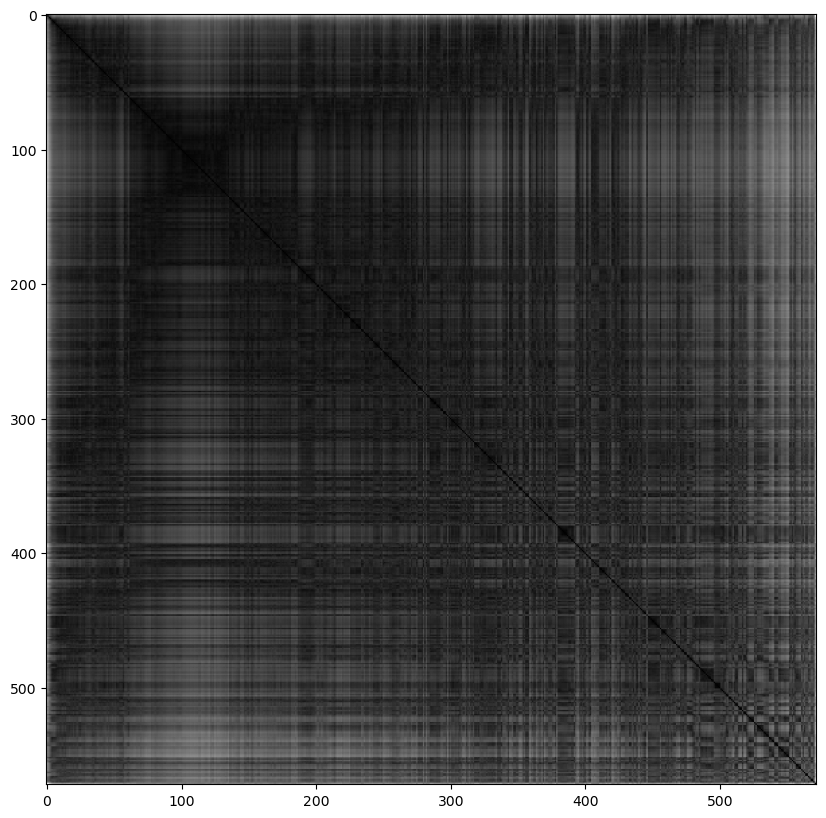

In [68]:
#explore cluster tendency of data
#https://pyclustertend.readthedocs.io/en/latest/
from pyclustertend import vat
from pyclustertend import ivat
from pyclustertend import hopkins

#create a normalized array
arr1 = scaled_full_no_chem.values


vat(arr1)
#ivat(arr1)
hopkins(arr1, 200) #closer to 0 means better clusters. 

In [69]:
#Fuzzy c-means clustering 
from fcmeans import FCM

my_model = FCM(n_clusters=2, m=10)
my_model.fit(arr1)

c_labels = my_model.predict(arr1)

all_chem_dropped['C-labels'] = c_labels

all_chem_dropped['C-labels'].value_counts()


1    297
0    275
Name: C-labels, dtype: int64